In [59]:
import sys

# Set the sys path to the main directory of the project
MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.utils.data as data

from utils.load import load_data
from utils.params import set_param

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from utils.data_preprocessing import create_dataset

import json

# Load the configuration file
with open("../conf.json", "r") as f:
    config = json.load(f)

# exp = 'b726'
# exp = 'b698'
# exp = 'i417'
exp = 'p4679'
# exp = "p4581"
# exp = 'cascadia'
# exp = 'sim_b726'
# exp = 'sim_b698'
# exp = 'sim_i417'

# Params for downsampling (specific to the dataset). Set downsampling factor to 
# value from conf file in order to make consistent with Cascadia time series.
SMOOTHING_WINDOW = 20
DOWNSAMPLING_FACTOR = config[exp]["downsampling_factor"]

# Now that we have a downsampling factor that makes each lab experiment 
# consistent with Cascadia - we set the number of lookback and forecast points
LOOKBACK = 600
FORECAST = 30

BATCH_SIZE = 32
EPOCHS = 50

# Set the seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

# Set torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [61]:
# TODO: Detrend only on train data and not the full dataset (else data leakage)

params = set_param(exp)

dirs = {"main": MAIN_DICT}
dirs["data"] = dirs["main"] + "/data/" + params["dir_data"]

X, _, t, _, _ = load_data(exp, dirs, params)

# `t.reshape(-1, 1)` is reshaping the `t` array. The `-1` in reshape function is
# a placeholder for "figure out what the dimension should be based on the length
# of the array and the other dimensions". The `1` means we want `t` to have one
# column. So, `t.reshape(-1, 1)` is reshaping `t` to have one column and as many
# rows as needed to accommodate the data.

# We need to reshape `t` because `np.hstack` requires the arrays of the same 
# dimensions.

# `np.hstack` horizontally stacks multiple arrays. In this case, it's stacking 
# the arrays `X` and `t.reshape(-1, 1)` side by side. The result is a single 2D 
# array where the first columns are from `X` and the last column is from `t`.

# The resulting 2D array is then turned into a pandas DataFrame, which is a 2D 
# labeled data structure with columns of potentially different types.
ts_raw = pd.DataFrame(np.hstack((X, t.reshape(-1, 1))), columns=["X", "t"])
ts_raw

,X,t
0,5.091520,0.000
1,5.090652,0.001
2,5.089989,0.002
3,5.089492,0.003
4,5.088243,0.004
...,...,...
301716,4.979753,301.716
301717,4.979841,301.717
301718,4.980150,301.718
301719,4.979985,301.719


Text(0.5, 1.0, 'Raw shear stress vs index')

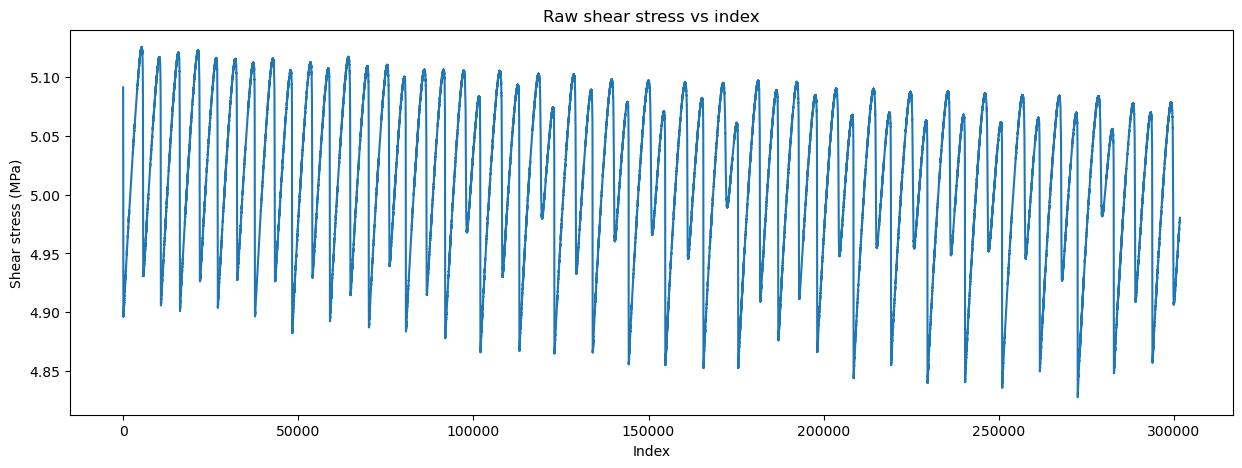

In [62]:
plt.figure(figsize=(15, 5))
plt.plot(ts_raw["X"])
plt.xlabel("Index")
plt.ylabel("Shear stress (MPa)")
plt.title("Raw shear stress vs index")

# Not plotting derivative and log derivative for now as signal is too noisy at 
# this stage

Text(0.5, 1.0, 'De-noised, downsampled shear stress vs index')

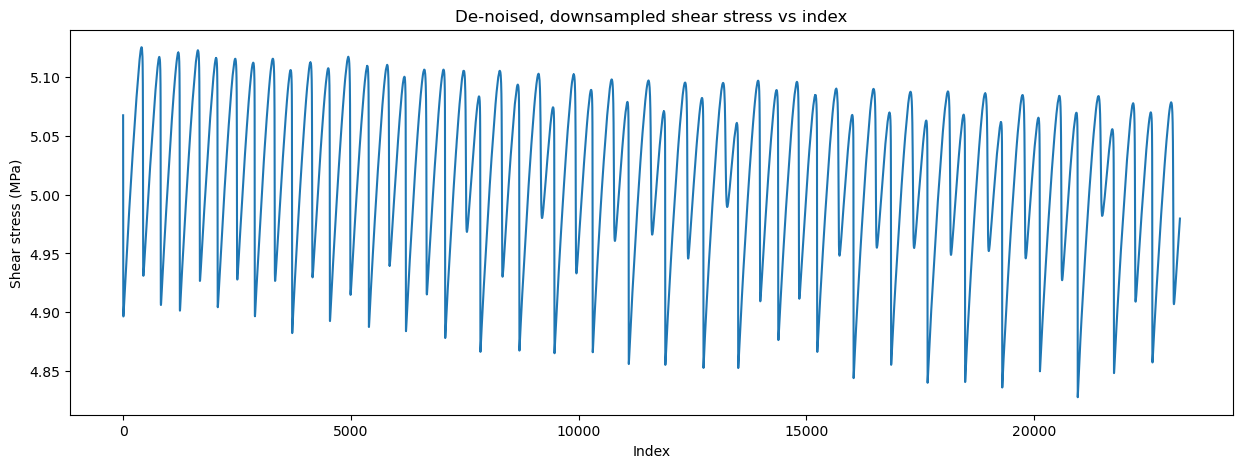

In [63]:
# Downsample to remove noise (smoothing) and make forecasting easier (less 
# points to predict)

# Apply a rolling window function with a specific window size and step size, 
# then calculate the mean for each window. This is a way of downsampling the 
# data, reducing its size and smoothing out short-term fluctuations.
# The dropna() function is used to remove any resulting missing values.
ts_smoothed = ts_raw.rolling(window=SMOOTHING_WINDOW, step=DOWNSAMPLING_FACTOR).mean().dropna()

# Reset the index of the DataFrame. The 'drop=True' argument is used to avoid 
# the old index being added as a column.
ts_smoothed = ts_smoothed.reset_index(drop=True)

# Plot the downsampled data
plt.figure(figsize=(15, 5))
plt.plot(ts_smoothed["X"])
plt.xlabel("Index")
plt.ylabel("Shear stress (MPa)")
plt.title("De-noised, downsampled shear stress vs index")

torch.Size([22579, 600]) torch.Size([22579, 30])


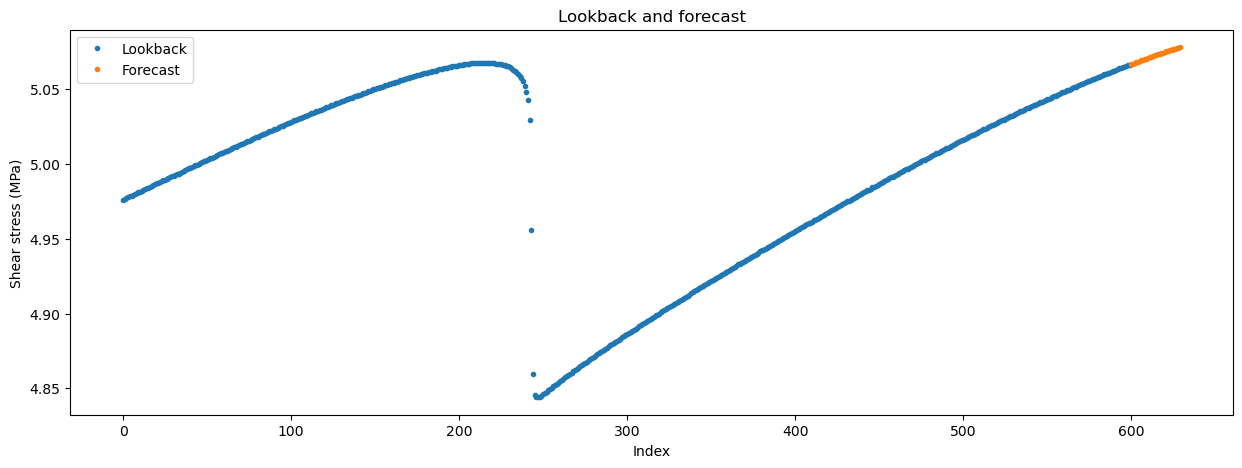

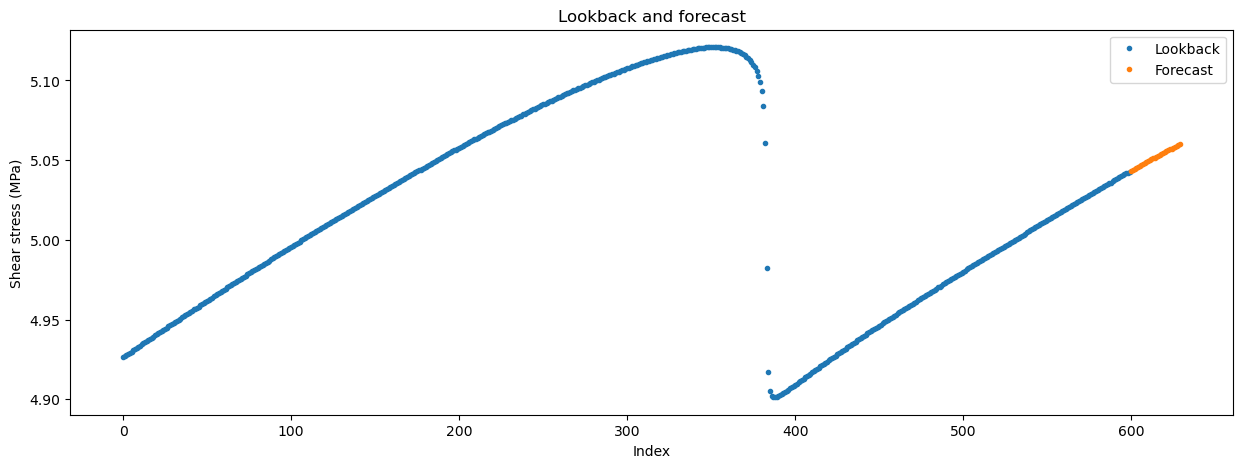

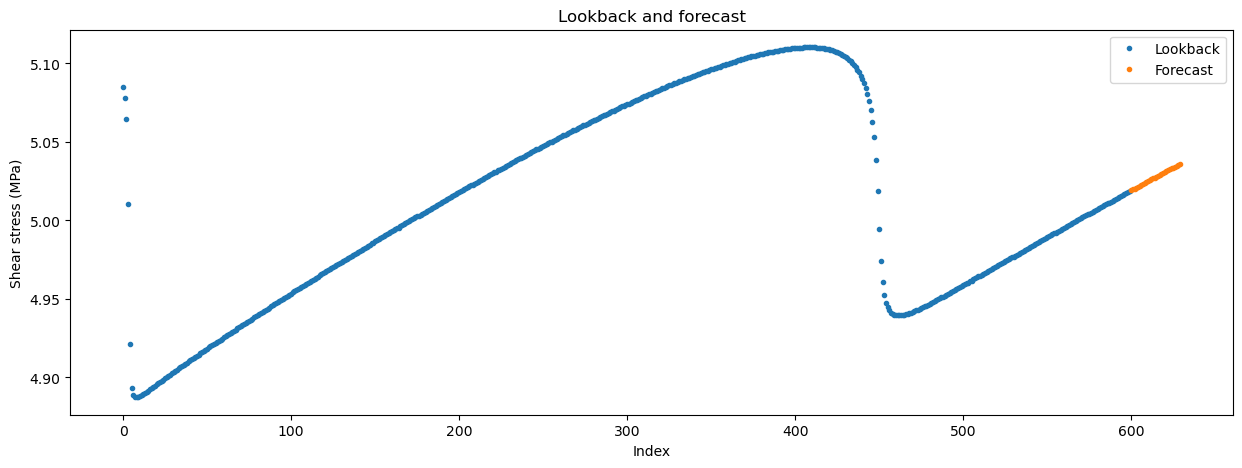

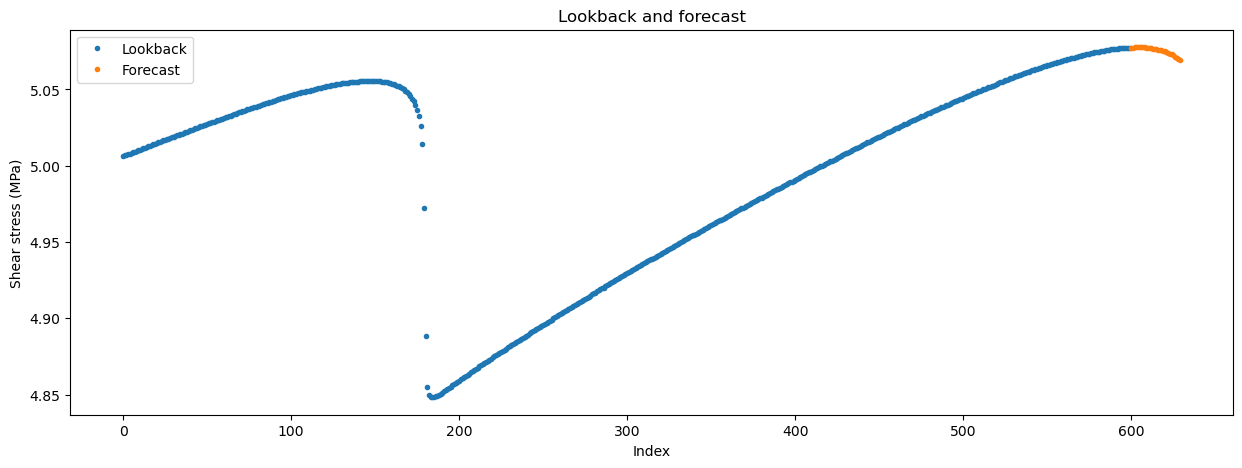

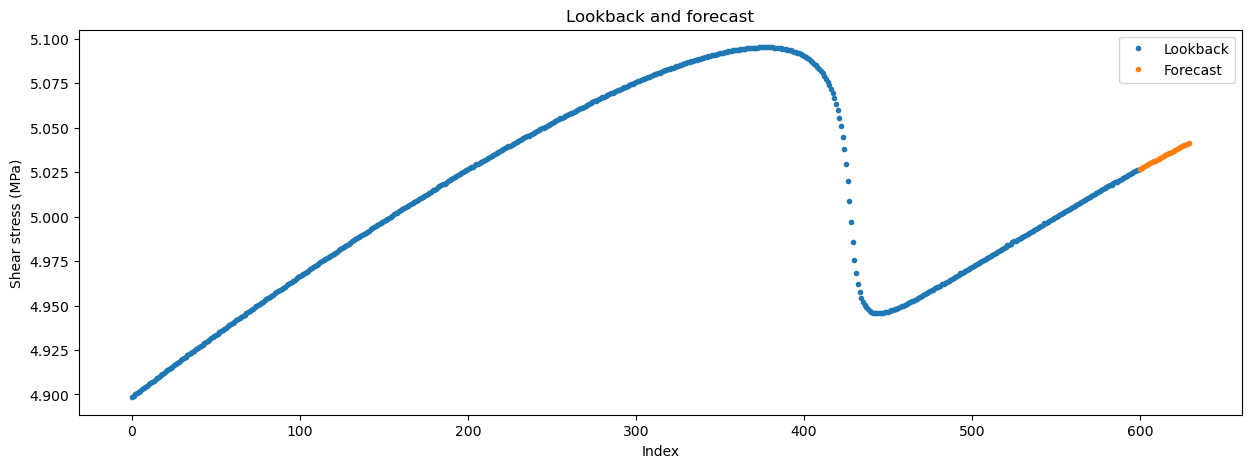

In [64]:
# Create windows (X lookback) and targets (y forecast) for the model
X, y = create_dataset(ts_smoothed["X"], lookback=LOOKBACK, forecast=FORECAST)

print(X.shape, y.shape)

# Display 5 windows (lookback and forecast) at random
for _ in range(5):
    i = np.random.randint(0, X.shape[0])
    plt.figure(figsize=(15, 5))
    plt.plot(X[i], '.', label="Lookback")
    plt.plot(np.arange(X.shape[1], X.shape[1] + y.shape[1]), y[i], '.', label="Forecast")
    plt.xlabel("Index")
    plt.ylabel("Shear stress (MPa)")
    plt.title("Lookback and forecast")
    plt.legend()

In [65]:
# Split train, val and test
train_val_test_split = (0.7, 0.15, 0.15)

def split_data(X, y, train_val_test_split):
    train_size = int(train_val_test_split[0] * X.shape[0])
    val_size = int(train_val_test_split[1] * X.shape[0])

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, train_val_test_split)

print(f"Train size: {X_train.shape[0]}")
print(f"Val size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Train size: 15805
Val size: 3386
Test size: 3388


In [66]:
# TODO: This is where I would de-trend?

# Scale the data
def normalise_dataset(ts_smoothed, X_train, X_val, X_test, y_train, y_val, y_test):
    scaler = StandardScaler()

    # Fit the scaler on the whole dataset X values in ts_smoothed
    # TODO: Should I only be using the training data to fit the scaler?
    scaler.fit_transform(X_train.reshape(-1, 1))

    # Transform the train, val and test sets
    X_train_sc = scaler.transform(X_train.reshape(-1, 1))
    X_val_sc = scaler.transform(X_val.reshape(-1, 1))
    X_test_sc = scaler.transform(X_test.reshape(-1, 1))
    y_train_sc = scaler.transform(y_train.reshape(-1, 1))
    y_val_sc = scaler.transform(y_val.reshape(-1, 1))
    y_test_sc = scaler.transform(y_test.reshape(-1, 1))

    # Reshape the data to be 3D for the LSTM model
    X_train_sc = X_train_sc.reshape(-1, LOOKBACK)
    X_val_sc = X_val_sc.reshape(-1, LOOKBACK)
    X_test_sc = X_test_sc.reshape(-1, LOOKBACK)
    y_train_sc = y_train_sc.reshape(-1, FORECAST)
    y_val_sc = y_val_sc.reshape(-1, FORECAST)
    y_test_sc = y_test_sc.reshape(-1, FORECAST)


    # make everything a tensor
    X_train = torch.tensor(X_train).float()
    X_val = torch.tensor(X_val).float()
    X_test = torch.tensor(X_test).float()
    y_train = torch.tensor(y_train).float()
    y_val = torch.tensor(y_val).float()
    y_test = torch.tensor(y_test).float()

    X_train_sc = torch.tensor(X_train_sc).float()
    X_val_sc = torch.tensor(X_val_sc).float()
    X_test_sc = torch.tensor(X_test_sc).float()
    y_train_sc = torch.tensor(y_train_sc).float()
    y_val_sc = torch.tensor(y_val_sc).float()
    y_test_sc = torch.tensor(y_test_sc).float()


    data_dict = {
        "X_train": X_train,
        "X_val": X_val,
        "X_test": X_test,
        "y_train": y_train,
        "y_val": y_val,
        "y_test": y_test,
        "X_train_sc": X_train_sc,
        "X_val_sc": X_val_sc,
        "X_test_sc": X_test_sc,
        "y_train_sc": y_train_sc,
        "y_val_sc": y_val_sc,
        "y_test_sc": y_test_sc,
    }


    # Return the data and the scaler so that we can inverse transform the data
    # output by the model to get the original values to compare with the true
    # values
    return data_dict, scaler

data_dict, scaler = normalise_dataset(ts_smoothed, X_train, X_val, X_test, y_train, y_val, y_test)

/tmp/ipykernel_21675/558142007.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
/tmp/ipykernel_21675/558142007.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val).float()
/tmp/ipykernel_21675/558142007.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float()
/tmp/ipykernel_21675/558142007.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requir

Text(0, 0.5, 'Normalised shear stress (MPa)')

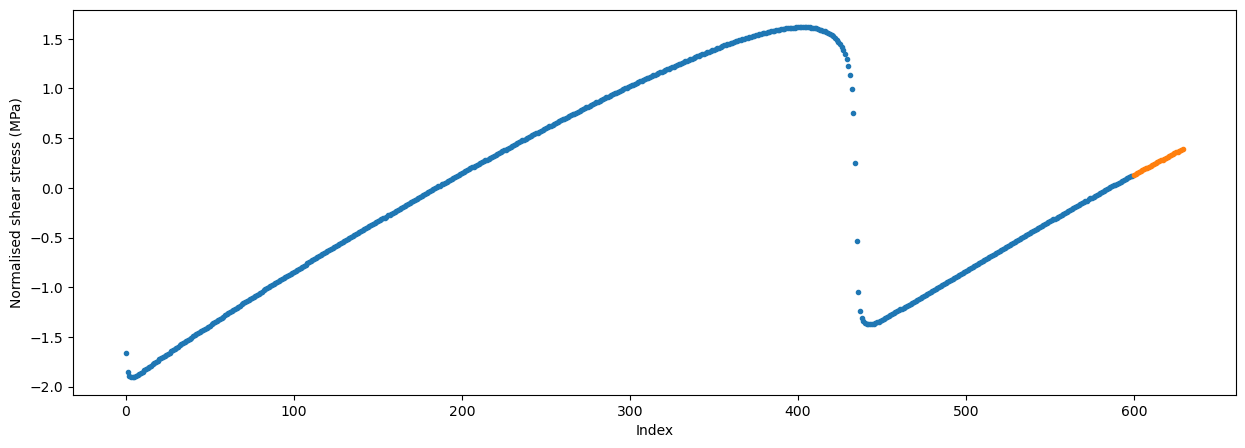

In [67]:
# Plot an example X and y sample post pre-processing
plt.figure(figsize=(15, 5))
plt.plot(data_dict["X_train_sc"][2], '.', label="Lookback")
plt.plot(np.arange(data_dict["X_train_sc"].shape[1], data_dict["X_train_sc"].shape[1] + data_dict["y_train"].shape[1]), data_dict["y_train_sc"][2], '.', label="Forecast")
plt.xlabel("Index")
plt.ylabel("Normalised shear stress (MPa)")

In [68]:
# LSTM model to carry out multi-step forecasting along forecast
# input: [batch size, lookback, 1]
# output: [batch size, forecast, 1]

# Input: batch of samples, each of length lookback
# Output: batch of samples, each of length forecast
# Model: LSTM that takes lookback samples and outputs forecast samples

# TODO: TRy adding another layer with a non-linear activation function
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=FORECAST):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        # Fully connected layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Initialise hidden state and cell state
        h0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(device)
        c0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(device)

        # LSTM layer
        lstm_out, _ = self.lstm(input_seq, (h0, c0))

        # Only take the output from the final timestep
        predictions = self.linear(lstm_out[:, -1, :])

        return predictions

In [69]:
# Train the model
model = LSTM().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# data loader
train_loader = data.DataLoader(
    data.TensorDataset(data_dict["X_train_sc"], data_dict["y_train_sc"]), batch_size=BATCH_SIZE
)

val_loader = data.DataLoader(
    data.TensorDataset(data_dict["X_val_sc"], data_dict["y_val"]), batch_size=BATCH_SIZE
)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X.unsqueeze(2).float())
        loss = loss_fn(pred.unsqueeze(2), y.unsqueeze(2).float())

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  # zero the gradients after updating for the next batch

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

     
def test(dataloader, model, loss_fn, scaler):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.unsqueeze(2).float())
            # Un-scale the pred value using the scaler.inverse_transform
            pred_np = pred.cpu().numpy()
            pred_unscaled = scaler.inverse_transform(pred_np)
            pred_unscaled = torch.from_numpy(pred_unscaled)
            # Un-scale the y values
            y_np = y.cpu()
            # Calculate the loss with the unscaled values
            test_loss += loss_fn(pred_unscaled, y_np).item()
    test_loss /= num_batches
    print(f"Loss: \n Avg loss: {test_loss:>8f} \n")
    print(f"RMSE: {np.sqrt(test_loss):.8f}")
    return np.sqrt(test_loss)
    # print(f"R^2: {1 - test_loss / np.var(y_np):.8f}")


rmses = []
for i in range(EPOCHS):
    print(f"Epoch {i+1}\n-------------------------------")
    train(train_loader, model, loss_function, optimizer)
    rmses.append(test(val_loader, model, loss_function, scaler))

# Plot the RMSEs
plt.figure(figsize=(15, 5))
plt.plot(rmses)
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Val RMSE vs Epoch")

Epoch 1
-------------------------------
loss: 0.158853  [   32/15805]
loss: 0.303837  [  352/15805]
loss: 2.578249  [  672/15805]
loss: 0.629789  [  992/15805]
loss: 0.053044  [ 1312/15805]
loss: 0.064679  [ 1632/15805]
loss: 0.660676  [ 1952/15805]
loss: 0.588521  [ 2272/15805]
loss: 0.063141  [ 2592/15805]
loss: 0.090102  [ 2912/15805]
loss: 0.022948  [ 3232/15805]
loss: 2.168677  [ 3552/15805]
loss: 0.188671  [ 3872/15805]
loss: 0.028394  [ 4192/15805]
loss: 0.018007  [ 4512/15805]
loss: 0.580180  [ 4832/15805]
loss: 0.150486  [ 5152/15805]
loss: 0.034402  [ 5472/15805]
loss: 0.004746  [ 5792/15805]
loss: 0.006924  [ 6112/15805]
loss: 0.167101  [ 6432/15805]
loss: 0.040132  [ 6752/15805]
loss: 0.006306  [ 7072/15805]
loss: 0.005612  [ 7392/15805]
loss: 0.933393  [ 7712/15805]
loss: 0.095967  [ 8032/15805]
loss: 0.014393  [ 8352/15805]
loss: 0.007342  [ 8672/15805]
loss: 0.000974  [ 8992/15805]
loss: 0.110053  [ 9312/15805]
loss: 0.127029  [ 9632/15805]
loss: 0.008340  [ 9952/15805]


In [70]:
# Test the model
test_loader = data.DataLoader(
    data.TensorDataset(data_dict["X_test_sc"], data_dict["y_test"]), batch_size=BATCH_SIZE
)

test(test_loader, model, loss_function, scaler)

Loss: 
 Avg loss: 0.000408 

RMSE: 0.02019089


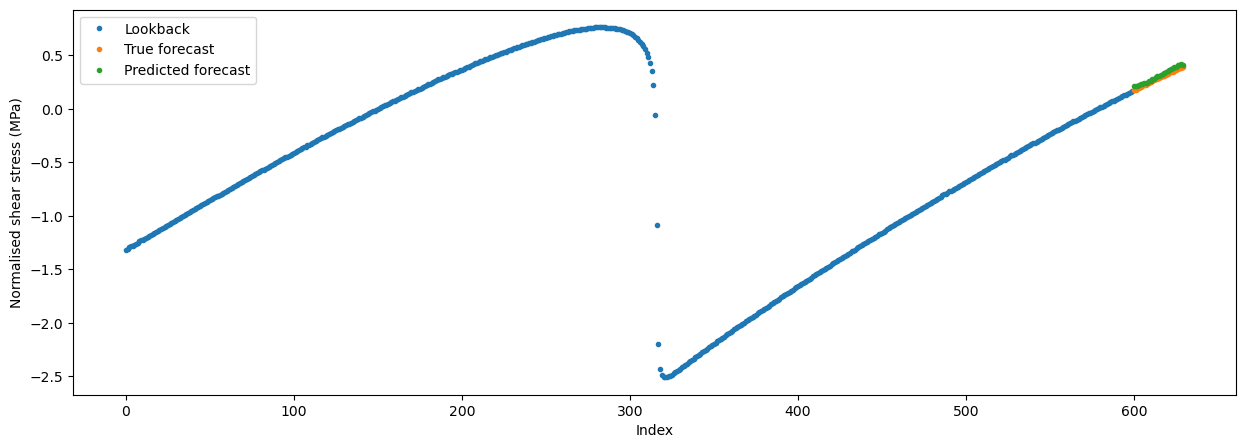

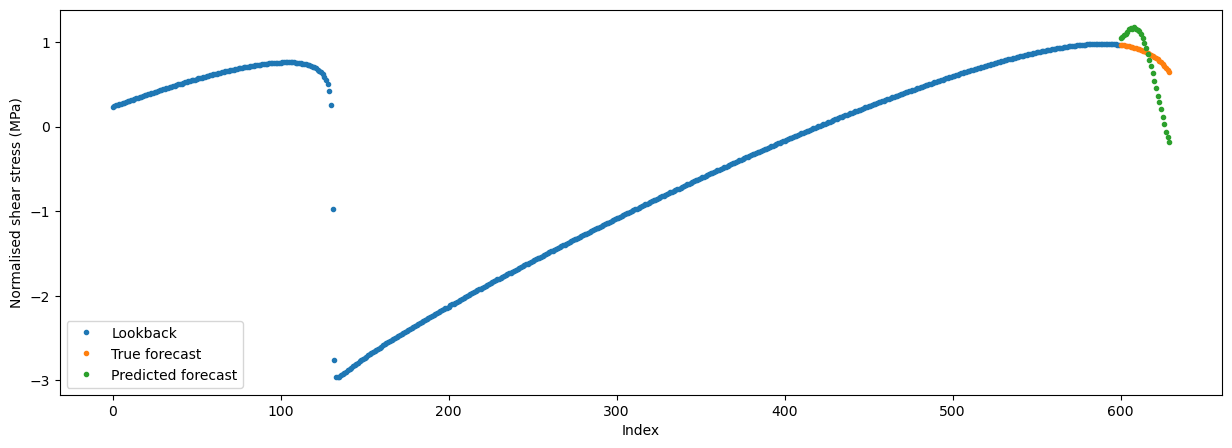

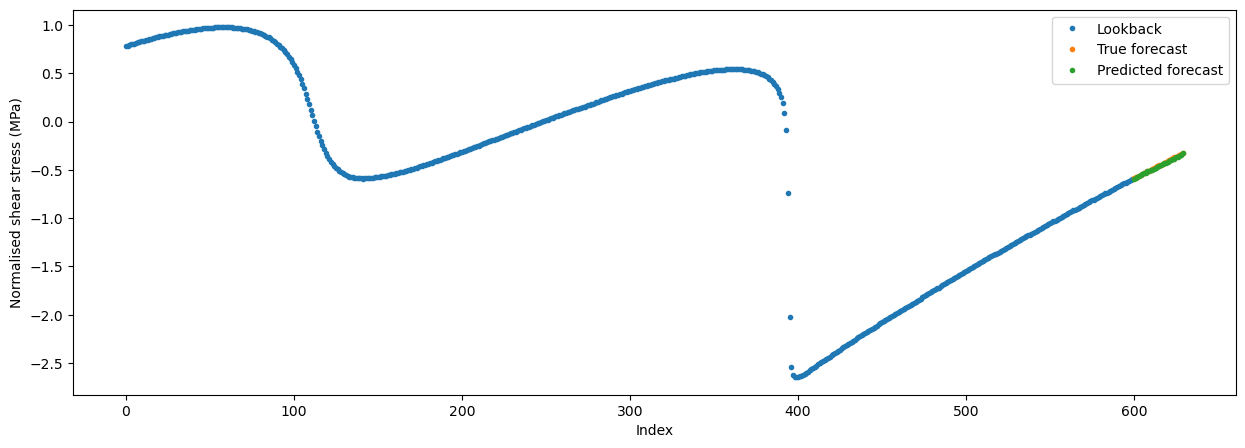

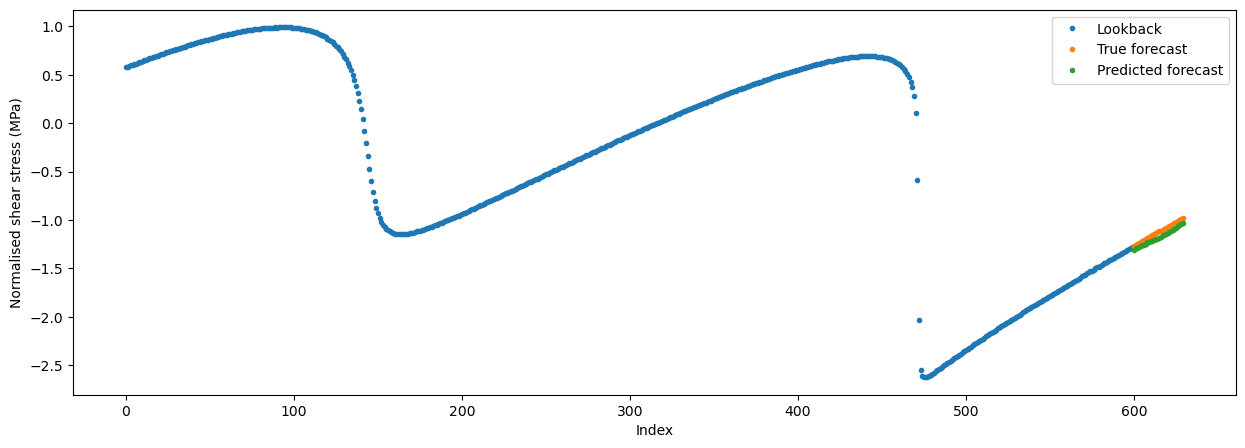

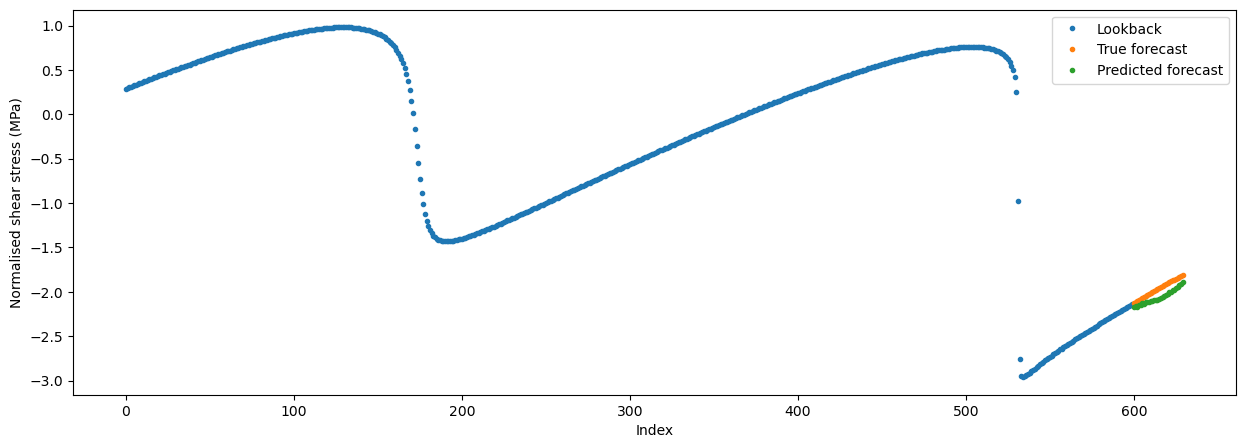

In [71]:
# Output 5 random predictions from the test set
for _ in range(5):
    i = np.random.randint(0, data_dict["X_test_sc"].shape[0])
    
    # Make a prediction without data loader
    pred = model(data_dict["X_test_sc"][i].unsqueeze(0).unsqueeze(2).float().to(device))

    plt.figure(figsize=(15, 5))
    plt.plot(data_dict["X_test_sc"][i], '.', label="Lookback")
    plt.plot(np.arange(data_dict["X_test_sc"].shape[1], data_dict["X_test_sc"].shape[1] + data_dict["y_test_sc"].shape[1]), data_dict["y_test_sc"][i], '.', label="True forecast")
    plt.plot(np.arange(data_dict["X_test_sc"].shape[1], data_dict["X_test_sc"].shape[1] + data_dict["y_test_sc"].shape[1]), pred.cpu().detach().numpy().flatten(), '.', label="Predicted forecast")
    plt.xlabel("Index")
    plt.ylabel("Normalised shear stress (MPa)")
    plt.legend()
